[22:40:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


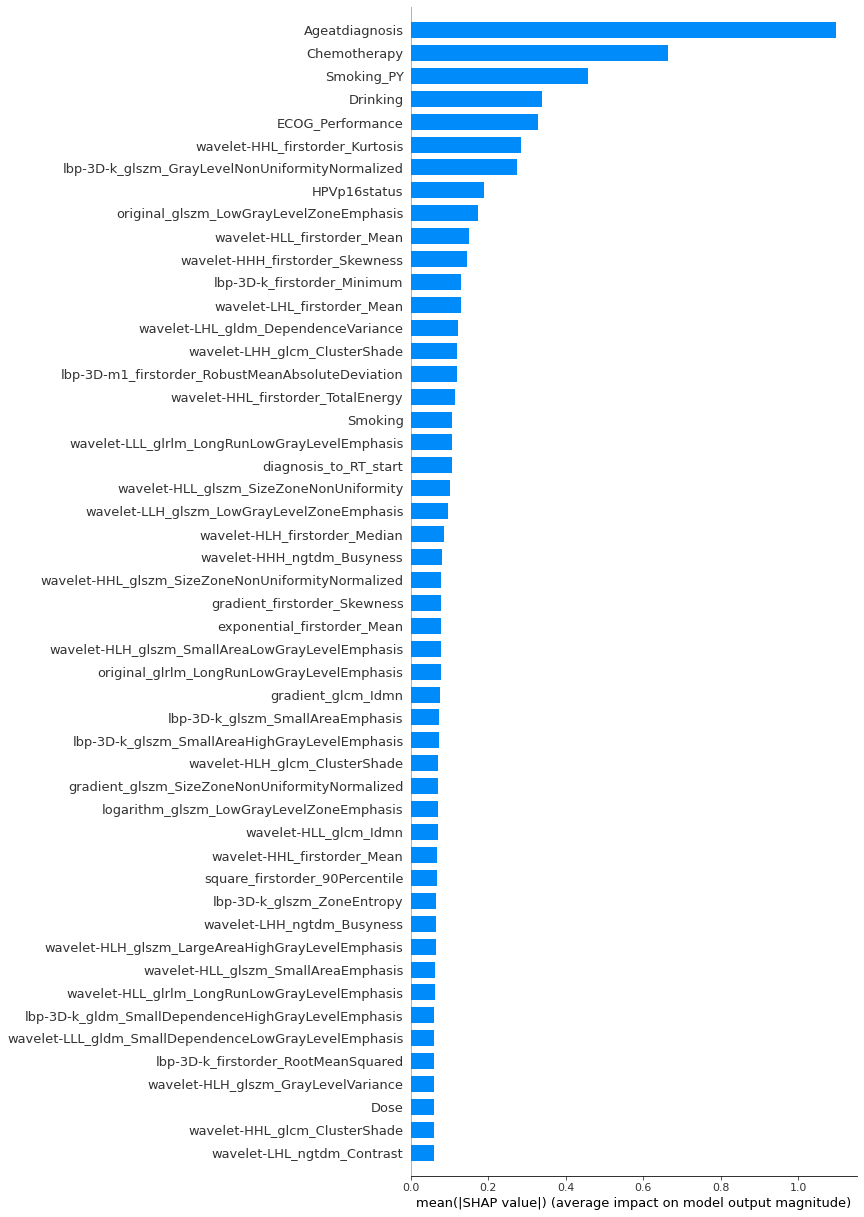

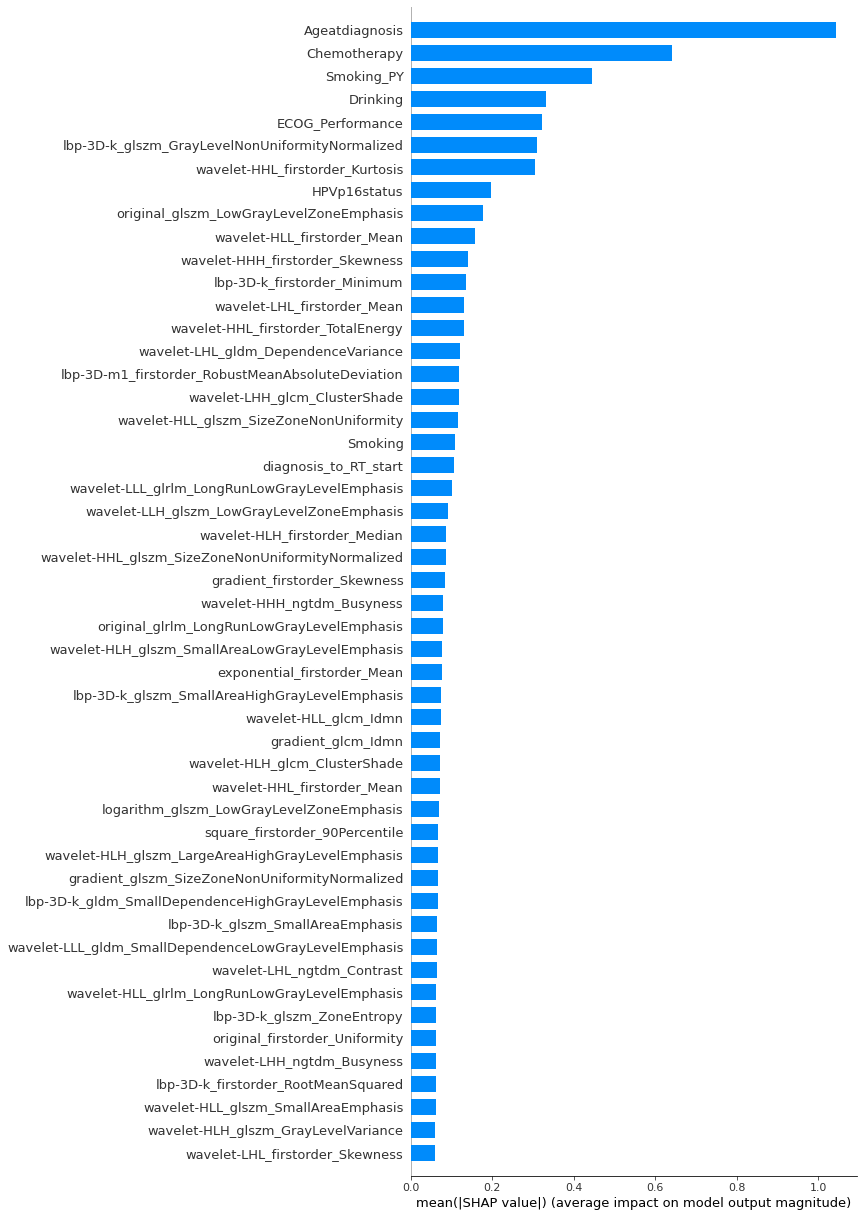

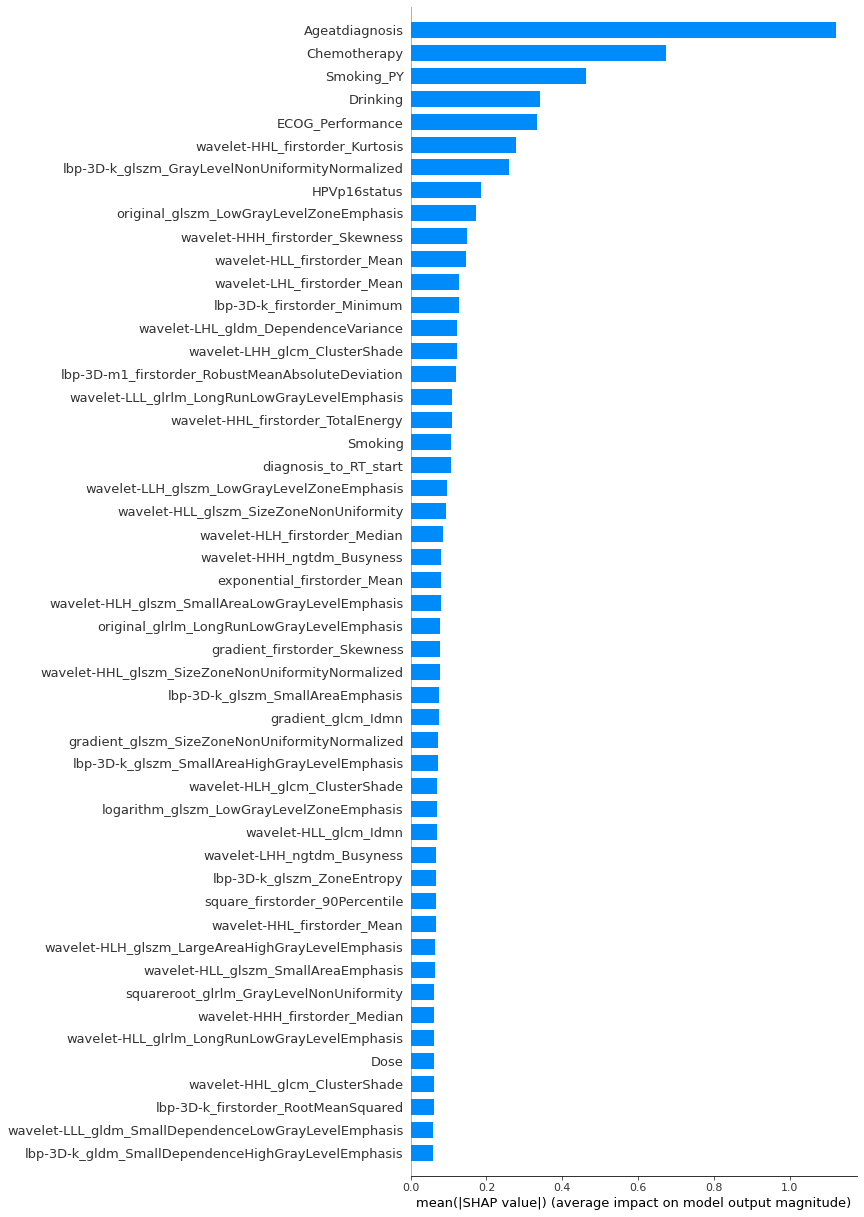

In [3]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import explain_prediction
import shap
from sklearn.metrics import precision_score, roc_curve, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR, SVC
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings('ignore')
shap.initjs()
# xgboost回归top排序
def sort_features_r(shap_values, X_test_lifetime, max_display, Train_X, Train_y):
    print("---------------------------保留前" + str(max_display))
    shit = pd.DataFrame()
    fuck = select_feature_byImportance(shap_values, X_test_lifetime.columns, max_display=max_display)
    for x in fuck:
        shit[x] = Train_X[x]
    print(shit)
    X_train_lifetime, X_test_lifetime, y_train_lifetime, y_test_lifetime = train_test_split(shit, Train_y,
                                                                                            test_size=0.3)
    model_xgb = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100)
    model_xgb.fit(X_train_lifetime, y_train_lifetime)
    preds_test = model_xgb.predict(X_test_lifetime)
    print("rScore:")
    print(metrics.r2_score(y_test_lifetime, preds_test))
    print("mse:")
    print(mean_squared_error(y_test_lifetime, preds_test))
    print("mae:")
    print(mean_absolute_error(y_test_lifetime, preds_test))


# svm回归top排序
def sort_features_svr(shap_values, X_test_lifetime, max_display, Train_X,Train_y):
    print("---------------------------保留前" + str(max_display))
    shit = pd.DataFrame()
    fuck = select_feature_byImportance(shap_values, X_test_lifetime.columns, max_display)
    for x in fuck:
        shit[x] = Train_X[x]
    X_train_lifetime, X_test_lifetime, y_train_lifetime, y_test_lifetime = train_test_split(shit, Train_y,
                                                                                            test_size=0.3)
    linear_svr = SVR(kernel='linear')
    linear_svr.fit(X_train_lifetime, y_train_lifetime)
    preds_test = linear_svr.predict(X_test_lifetime)
    print("rScore:")
    print(metrics.r2_score(y_test_lifetime, preds_test))
    print("mse:")
    print(mean_squared_error(y_test_lifetime, preds_test))
    print("mae:")
    print(mean_absolute_error(y_test_lifetime, preds_test))

# 重新训练包含top x特征的模型
def sort_features_c(shap_values, X_test_status, max_display, Train_X, Train_z):

    print("---------------------------保留前" + str(max_display))
    shit = pd.DataFrame()
    fuck = select_feature_byImportance(shap_values, X_test_status.columns, max_display)
    #     print(fuck)
    for x in fuck:
        shit[x] = Train_X[x]
    print(shit.columns.shape)
    X_train_status, X_test_status, y_train_status, y_test_status = train_test_split(shit, Train_z, test_size=0.3)
    # xgboost分类
    model_xgb = xgb.XGBClassifier()
    model_xgb.fit(X_train_status, y_train_status)
    train_pre_status = model_xgb.predict(X_train_status)
    test_pre_status = model_xgb.predict(X_test_status)
    # train_pre_proba = model_xgb.predict_proba(X_train_status)
    # test_pre_proba = model_xgb.predict_proba(X_test_status)

    # svc分类
    # model_svc = svm.SVC().fit(X_train_status, y_train_status)
    # train_pre_status = model_svc.predict(X_train_status)
    # test_pre_status = model_svc.predict(X_test_status)
    train_auc = roc_auc_score(y_train_status, train_pre_status)
    test_auc = roc_auc_score(y_test_status, test_pre_status)
    train_acc = accuracy_score(y_train_status,train_pre_status)
    test_acc = accuracy_score(y_test_status, test_pre_status)
    
    train_a = 'train_auc:'
    test_a = 'test_auc:'
    train_ac = 'train_acc:'
    test_ac = 'test_acc:'
    print(train_a + str(train_auc))
    print(test_a + str(test_auc))
    print(train_ac + str(train_acc))
    print(test_ac + str(test_acc))


# 去掉前二十
def delete_20(shap_values, X_test_status, max_display, Train_X, Train_z):
    print("去掉前二十")
    shit = pd.DataFrame()
    #     print(Train_X.columns)
    fuck = select_feature_byImportance(shap_values, X_test_status.columns, max_display)
    #     print(fuck)
    for x in Train_X.columns:
        if (x not in fuck):
            shit[x] = Train_X[x]
    print(shit.columns.shape)
    X_train_status, X_test_status, y_train_status, y_test_status = train_test_split(shit, Train_z, test_size=0.3)
    # xgboost
    model_xgb = xgb.XGBClassifier()
    model_xgb.fit(X_train_status, y_train_status)

    train_pre_status = model_xgb.predict(X_train_status)
    test_pre_status = model_xgb.predict(X_test_status)
    # train_pre_proba = model_xgb.predict_proba(X_train_status)
    # test_pre_proba = model_xgb.predict_proba(X_test_status)
    # svc
    # model_svc = SVC().fit(X_train_status, y_train_status)
    # train_pre_status = model_svc.predict(X_train_status)
    # test_pre_status = model_svc.predict(X_test_status)
    train_auc = roc_auc_score(y_train_status, train_pre_status)
    test_auc = roc_auc_score(y_test_status, test_pre_status)
    train_acc = accuracy_score(y_train_status,train_pre_status)
    test_acc = accuracy_score(y_test_status, test_pre_status)

    train_a = 'train_auc:'
    test_a = 'test_auc:'
    train_ac = 'train_acc:'
    test_ac = 'test_acc:'
    print(train_a + str(train_auc))
    print(test_a + str(test_auc))
    print(train_ac + str(train_acc))
    print(test_ac + str(test_acc))


# 特征划分函数
def select_feature_byImportance(shap_values, feature_names, max_display):
    # 通过shap值进行排序
    feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0))
    print(feature_names.shape)
    # 选择排行top x的特征
    feature_inds = feature_order[-max_display:]
    # print(feature_inds)
    # for i in feature_inds:
    #     print(feature_names[i])

    # global_shap_values = np.abs(shap_values).mean(0)
    # for x in feature_inds:
    #     print(global_shap_values[x])

    return [feature_names[i] for i in feature_inds]


def dataprocessing(data):
    dummies_Sex = pd.get_dummies(data['Sex'], prefix='Sex')
    dummies_Sex = pd.DataFrame(dummies_Sex)

    ECOG = {'ECOG 0': 0, 'ECOG 1': 1, 'ECOG 2': 2, 'ECOG 3': 3, 'ECOG 4': 4}
    data["ECOG_Performance"] = data["ECOG_Performance"].map(ECOG)

    smoker = {'Non-smoker': 0, 'Ex-smoker': 1, 'Current': 2}
    data["Smoking"] = data["Smoking"].map(smoker)

    drinker = {'non-drinker': 0, 'light': 1, 'Moderate': 2, 'ex-drinker': 3, 'heavy': 4, 'unknown': 5}
    data["Drinking"] = data["Drinking"].map(drinker)

    sub = {'post wall': 1, 'Tonsillar Fossa': 2, 'Base of Tongue': 3, 'Tonsil ': 4,
           'Tonsil Pillar ': 5, 'Soft Palate ': 6, 'Vallecula': 7, 'lat wall': 0}
    data["Subsite"] = data["Subsite"].map(sub)

    T = {'T1': 1, 'T2': 2, 'T3': 3, 'T3 (2) ': 4, 'T4a': 5, 'T4b': 0}
    data["T"] = data["T"].map(T)

    N = {'N0': 0, 'N1': 1, 'N2a': 2, 'N2b': 3, 'N2c': 4, 'N3': 5}
    data["N"] = data["N"].map(N)

    M = {'M0': 0}
    data["M"] = data["M"].map(M)

    stage = {'I': 0, 'II': 1, 'III': 2, 'IVA': 3, 'IVB': 4}
    data["Stage"] = data["Stage"].map(stage)

    Hpv = {'  Negative': 0, '  positive': 1}
    data["HPVp16status"] = data["HPVp16status"].map(Hpv)

    Che = {'none': 0, 'Yes': 1}
    data["Chemotherapy"] = data["Chemotherapy"].map(Che)

    RT = {'IMRT': 0, 'IMRT-ipsilat': 1}
    data["RT_Tech"] = data["RT_Tech"].map(RT)

    Status = {'Dead': 0, 'Alive': 1}
    data["Status"] = data["Status"].map(Status)

    data.drop(['PatientID', 'Sex', 'Ds_Site', 'Path', 'Primary_Treatment', 'Cause_of_Death',
               'Local_Failure', 'local_failure(days)', 'Regional_Failure', 'regional_failure(days)',
               'Distant_Failure', 'distant_failure (days)', 'Second_Primary', '2nd_cancer_(days)',
               'PMID', 'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
               'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python',
               'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes',
               'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Dimensionality',
               'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size',
               'diagnostics_Image-original_Mean',
               'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum',
               'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing',
               'diagnostics_Mask-original_Size',
               'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_VoxelNum',
               'diagnostics_Mask-original_VolumeNum', 'diagnostics_Mask-original_CenterOfMassIndex',
               'diagnostics_Mask-original_CenterOfMass'

               ], axis=1, inplace=True)

    data_df = pd.concat([data, dummies_Sex], axis=1)
    return data_df
# 处理训练数据
train_data = 'train_data.csv'
data_train = pd.read_csv(train_data)
dataprocessing(data_train)
data_train = data_train.fillna(0)

Train_X = data_train.drop(['FU', 'Status'], axis=1)
#Train_X = data_train.drop(['Status'],axis=1)
Train_y = data_train.pop('FU').values
Train_z = data_train.pop('Status').values
colNames = Train_X.columns

stdScale = StandardScaler().fit(Train_X) ## 生成规则
Train_X = stdScale.transform(Train_X) ## 将规则应用于训练集
Train_X = pd.DataFrame(Train_X)
Train_X.columns = colNames
# X_train_lifetime, X_test_lifetime, y_train_lifetime, y_test_lifetime = train_test_split(x, y, test_size=0.3)
x_train, x_test, y_train, y_test = train_test_split(Train_X, Train_z, test_size=0.3)

# print(z_status)

# 训练XGboost
# 回归
# model_xgb = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100)
# model_xgb.fit(X_train_lifetime, y_train_lifetime)
# preds_test = model_xgb.predict(X_test_lifetime)
# 分类
model_xgb = xgb.XGBClassifier()
model_xgb.fit(x_train, y_train)

train_pre_status = model_xgb.predict(x_train)
test_pre_status = model_xgb.predict(x_test)

# train_pre_proba = model_xgb.predict_proba(X_train_status)
# test_pre_proba = model_xgb.predict_proba(X_test_status)

# 训练svc
# model_svc = SVC()
# model_svc.fit(x_train, y_train)
# train_pre_status = model_svc.predict(x_train)
# test_pre_status = model_svc.predict(x_test)
# print(x_train.shape)
# print(x_train.columns)


train_auc = roc_auc_score(y_train, train_pre_status)
test_auc = roc_auc_score(y_test, test_pre_status)
train_acc = accuracy_score(y_train, train_pre_status)
test_acc = accuracy_score(y_test, test_pre_status)

train_a = 'train_auc:'
test_a = 'test_auc:'
train_ac = 'train_acc:'
test_ac = 'test_acc:'

# roc曲线
# Xgbc_fpr,Xgbc_tpr,Xgbc_threasholds=roc_curve(y_test_status,test_pre_proba[:,1]) # 计算ROC的值,svm_threasholds为阈值
# plt.title("roc_curve of %s(AUC=%.4f)" %('Xgbc_test',test_auc))
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.plot(Xgbc_fpr,Xgbc_tpr)
# plt.show()


# 训练svr
# linear_svr = SVR(kernel='linear')
# linear_svr.fit(X_train_lifetime, y_train_lifetime)
# preds_test = linear_svr.predict(X_test_lifetime)
# #print(preds_test)
# print("--------------------------------")
# # print(preds_test)
# #回归评估
# # print(preds_test)
# # print("------------------------------------")
# # print(y_test_lifetime)
# print("---------------------------保留全部------------------------------------")
# print("rScore:")
# print(metrics.r2_score(y_test_lifetime, preds_test))
# print("mse:")
# print(mean_squared_error(y_test_lifetime, preds_test))
# print("mae:")
# print(mean_absolute_error(y_test_lifetime, preds_test))

# Treeshap解释
explainer = shap.TreeExplainer(model_xgb)
shap_values_0 = explainer.shap_values(Train_X)
shap_values = explainer.shap_values(x_test)
shap_values_1 = explainer.shap_values(x_train)
# # print(shap_values.shape)
# # shap.plots.force(explainer.expected_value, shap_values[1],X_test_lifetime.columns)
# shap.summary_plot(shap_values, X_train_status,max_display=100)
shap.summary_plot(shap_values_0, Train_X.columns, plot_type="bar", max_display=50)
shap.summary_plot(shap_values, x_test.columns, plot_type="bar", max_display=50)
shap.summary_plot(shap_values_1, x_train.columns, plot_type="bar", max_display=50)
# shap.dependence_plot("Ageatdiagnosis", shap_values, X_train_status, interaction_index=None)
# shap.dependence_plot("Drinking", shap_values, X_train_status, interaction_index=None)
# shap.dependence_plot("Chemotherapy", shap_values, X_train_status, interaction_index=None)
# shap.dependence_plot("Smoking_PY", shap_values, X_train_status, interaction_index=None)
# shap.dependence_plot("HPVp16status", shap_values, X_train_status, interaction_index=None)
# # print(summary_legacy(shap_values,X_test_lifetime.columns,max_display=20))

# kernelExplainer法  svr svc
# X_train_summary = shap.kmeans(X_train_lifetime, 10)
# ex = shap.KernelExplainer(linear_svr.predict, X_train_summary)
# shap_values = ex.shap_values(X_test_lifetime)
# X_train_summary = shap.kmeans(x_train, 10)
# ex = shap.KernelExplainer(model_svc.predict, X_train_summary)
# shap_values = ex.shap_values(x_train)
# 去掉top20
# print("----------------------------保留全部----------------------------")
# print(x_train.columns.shape)
# print(train_a + str(train_auc))
# print(test_a + str(test_auc))
# print(train_ac + str(train_acc))
# print(test_ac + str(test_acc))
# delete_20(shap_values=shap_values, X_test_status=x_test, max_display=20, Train_X=Train_X, Train_z=Train_z)
# max = [20, 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
# # max = [20,50,100]
# for i in max:
#     sort_features_c(shap_values=shap_values, X_test_status=x_test, max_display=i, Train_X=Train_X,
#                     Train_z=Train_z)
#     sort_features_svr(shap_values,X_test_lifetime,max_display=x,Train_X=Train_X)

